In [1]:
import numpy as np
import pandas as pd

from developed_methods import *

In [16]:
dtrain = pd.read_csv("data/train.csv")
dtest = pd.read_csv("data/test.csv")

## mapping 
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(dtrain['user_id'], dtest["user_id"]))
dtrain['user_id'] = le_user.transform(dtrain["user_id"])
dtest["user_id"] = le_user.transform(dtest["user_id"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(dtrain['item_id'], dtest["item_id"]))
dtrain["item_id"] = le_item.transform(dtrain["item_id"])
dtest["item_id"] = le_item.transform(dtest["item_id"])

In [17]:
# split the train data into train and test dataset
dtest_real = dtest.copy() # create a copy for the real test dataset

from sklearn.model_selection import train_test_split
dtrain, dtest = train_test_split(dtrain, test_size=0.2, random_state=42)

# train_pair, train_rating
train_pair = dtrain[['user_id', 'item_id']].values
train_rating = dtrain['rating'].values

## save real ratings for test set for evaluation.
test_rating = np.array(dtest['rating'])
test_pair = dtest[['user_id', 'item_id']].values

## remove the ratings in the test set to simulate prediction
dtest = dtest.drop(columns='rating')

n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

In [18]:
## baseline user mean methods
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred_user = user_ave.predict(test_pair)
print('RMSE for user_mean: %.3f' %rmse(test_rating, pred_user) )

RMSE for user_mean: 1.959


In [19]:
## baseline item mean methods
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred_item = item_ave.predict(test_pair)
print('RMSE for item_mean: %.3f' %rmse(test_rating, pred_item) )

RMSE for item_mean: 2.850


3-Fold CV for K: 2; lam: 0.00000: train_rmse: 2.283, valid_rmse: 2.283
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 2.339, valid_rmse: 2.370
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 2.311, valid_rmse: 2.304
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 2.328, valid_rmse: 2.384
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 2.361, valid_rmse: 2.421
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 2.303, valid_rmse: 2.345
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 2.334, valid_rmse: 2.335
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 2.321, valid_rmse: 2.337
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 2.364, valid_rmse: 2.330
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 2.315, valid_rmse: 2.334
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 2.273, valid_rmse: 2.312
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 2.342, valid_rmse: 2.349
3-Fold CV for K: 2; lam: 0.00010: train_rmse: 2.317, valid_rmse: 2.281
3-Fold CV for K: 2; lam: 0.00010: train_rmse: 2.379, valid_rmse: 2.357
3-Fold

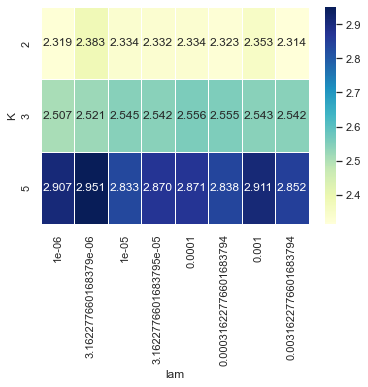

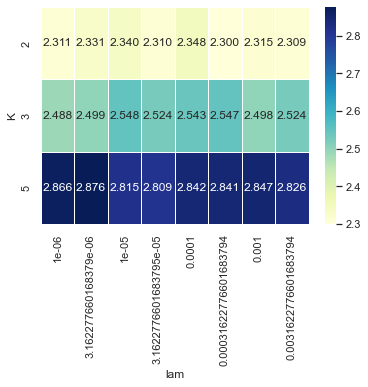

In [20]:
## CV based on `LFM_CV`
## Baseline + LFM
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
dtrain['res_rating'] = train_rating_res
pred = pred + user_ave.predict(test_pair)

# fit LFM_CV by residual ratings 
Ks, lams = [2, 3, 5], 10**np.arange(-6, -2, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

In [21]:
## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
print('best K: %d, best lam: %.5f' %(best_K, best_lam))
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
print('RMSE for glb + user_mean + LFM: %.3f' %rmse(test_rating, pred))

best K: 2, best lam: 0.00316
Fitting Reg-LFM: K: 2, lam: 0.00316
Reg-LFM: ite: 0; diff: 0.004 RMSE: 2.328
Reg-LFM: ite: 1; diff: 0.004 RMSE: 2.324
Reg-LFM: ite: 2; diff: 0.004 RMSE: 2.320
Reg-LFM: ite: 3; diff: 0.004 RMSE: 2.316
Reg-LFM: ite: 4; diff: 0.004 RMSE: 2.312
Reg-LFM: ite: 5; diff: 0.004 RMSE: 2.309
Reg-LFM: ite: 6; diff: 0.004 RMSE: 2.305
Reg-LFM: ite: 7; diff: 0.004 RMSE: 2.301
Reg-LFM: ite: 8; diff: 0.004 RMSE: 2.297
Reg-LFM: ite: 9; diff: 0.004 RMSE: 2.293
RMSE for glb + user_mean + LFM: 2.345


In [26]:
from sklearn.preprocessing import StandardScaler

user_info = pd.DataFrame({'user_id': list(range(n_user))})
user_info = user_info.set_index('user_id')
user_info['mean'] = dtrain.groupby('user_id')['res_rating'].mean()
user_info['q1'] = dtrain.groupby('user_id')['res_rating'].quantile(.1)
user_info['q3'] = dtrain.groupby('user_id')['res_rating'].quantile(.3)
user_info['q5'] = dtrain.groupby('user_id')['res_rating'].quantile(.5)
user_info['q7'] = dtrain.groupby('user_id')['res_rating'].quantile(.7)
user_info['q7'] = dtrain.groupby('user_id')['res_rating'].quantile(.9)
## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)

movie_info = pd.DataFrame({'user_id': list(range(n_item))})
movie_info = movie_info.set_index('user_id')
movie_info['mean'] = dtrain.groupby('user_id')['res_rating'].mean()
movie_info['q1'] = dtrain.groupby('user_id')['res_rating'].quantile(.1)
movie_info['q3'] = dtrain.groupby('user_id')['res_rating'].quantile(.3)
movie_info['q5'] = dtrain.groupby('user_id')['res_rating'].quantile(.5)
movie_info['q7'] = dtrain.groupby('user_id')['res_rating'].quantile(.7)
movie_info['q7'] = dtrain.groupby('user_id')['res_rating'].quantile(.9)
## fill NAN as the column mean
movie_info = movie_info.fillna(movie_info.mean())
movie_scaler = StandardScaler()
movie_info = movie_scaler.fit_transform(movie_info)

In [27]:
print(user_info)

[[ 0.05741306 -0.03952585 -0.07431135 -0.04514975 -0.21216079]
 [ 0.62937076  1.15164361  0.62642524 -1.07590514 -1.05366503]
 [ 6.59407258  1.90966054  1.50234599  0.2125391  -1.80166881]
 ...
 [ 1.14685631  1.00725943  0.04247808  0.64202051 -0.80433044]
 [ 0.05741306  0.42069872  0.84540543 -0.75379408 -0.28228614]
 [-1.7706358   0.49640864 -0.08321902 -0.57363027 -0.21691505]]


In [28]:
print(movie_info)

[[ 8.01562547e-02 -5.51833327e-02 -1.03748521e-01 -6.30350501e-02
  -2.96204650e-01]
 [ 8.78685212e-01  1.60784750e+00  8.74572872e-01 -1.50210653e+00
  -1.47105639e+00]
 [ 9.20620149e+00  2.66613985e+00  2.09747461e+00  2.96732819e-01
  -2.51536904e+00]
 ...
 [ 0.00000000e+00  3.35697295e-16 -2.71538734e-16  0.00000000e+00
   5.79709978e-16]
 [ 0.00000000e+00  3.35697295e-16 -2.71538734e-16  0.00000000e+00
   5.79709978e-16]
 [ 0.00000000e+00  3.35697295e-16 -2.71538734e-16  0.00000000e+00
   5.79709978e-16]]


In [29]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(user_info)
movie_sim = cosine_similarity(movie_info)

In [30]:
top = 5
index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):
	print('UserId: %d' %u)
	### find the top closest users for the user u
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	### extend the records' index for the users
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	### find observed items under top users
	obs_movie_tmp = train_pair[valid_user_ind,1]
	for i in range(n_item):
		### find top items 
		top_movie_tmp = movie_sim[i].argsort()[-top:][::-1]
		### find valid item: intersect with top-items and observed item
		valid_movie_tmp = np.intersect1d(top_movie_tmp, obs_movie_tmp)
		if len(valid_movie_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_movie_tmp:
			### extend all rating index for valid item
			valid_item_ind.extend(index_item[i_tmp])
		### find index close to (u,i)
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0
UserId: 1
UserId: 2
UserId: 3
UserId: 4
UserId: 5
UserId: 6
UserId: 7
UserId: 8
UserId: 9
UserId: 10
UserId: 11
UserId: 12
UserId: 13
UserId: 14
UserId: 15
UserId: 16
UserId: 17
UserId: 18
UserId: 19
UserId: 20
UserId: 21
UserId: 22
UserId: 23
UserId: 24
UserId: 25
UserId: 26
UserId: 27
UserId: 28
UserId: 29
UserId: 30
UserId: 31
UserId: 32
UserId: 33
UserId: 34
UserId: 35
UserId: 36
UserId: 37
UserId: 38
UserId: 39
UserId: 40
UserId: 41
UserId: 42
UserId: 43
UserId: 44
UserId: 45
UserId: 46
UserId: 47
UserId: 48
UserId: 49
UserId: 50
UserId: 51
UserId: 52
UserId: 53
UserId: 54
UserId: 55
UserId: 56
UserId: 57
UserId: 58
UserId: 59
UserId: 60
UserId: 61
UserId: 62
UserId: 63
UserId: 64
UserId: 65
UserId: 66
UserId: 67
UserId: 68
UserId: 69
UserId: 70
UserId: 71
UserId: 72
UserId: 73
UserId: 74
UserId: 75
UserId: 76
UserId: 77
UserId: 78
UserId: 79
UserId: 80
UserId: 81
UserId: 82
UserId: 83
UserId: 84
UserId: 85
UserId: 86
UserId: 87
UserId: 88
UserId: 89
UserId: 90
UserId: 9

In [31]:
aug_pair, aug_rating_res = np.vstack((train_pair, fake_pair)), np.hstack((train_rating_res, fake_rating))

## fit the LFM model with augmentated dataset
K, lam = 5, 0.0001
sSVD=LFM(n_user, n_item, K=K, lam=lam)
sSVD.fit(aug_pair, aug_rating_res)

Fitting Reg-LFM: K: 5, lam: 0.00010
Reg-LFM: ite: 0; diff: 0.076 RMSE: 2.781
Reg-LFM: ite: 1; diff: 0.071 RMSE: 2.710
Reg-LFM: ite: 2; diff: 0.066 RMSE: 2.644
Reg-LFM: ite: 3; diff: 0.062 RMSE: 2.582
Reg-LFM: ite: 4; diff: 0.058 RMSE: 2.525
Reg-LFM: ite: 5; diff: 0.054 RMSE: 2.471
Reg-LFM: ite: 6; diff: 0.050 RMSE: 2.421
Reg-LFM: ite: 7; diff: 0.047 RMSE: 2.374
Reg-LFM: ite: 8; diff: 0.044 RMSE: 2.330
Reg-LFM: ite: 9; diff: 0.041 RMSE: 2.289


In [32]:
## Baseline + LFM
pred = glb_ave.predict(test_pair)
# user_mean
pred = pred + user_ave.predict(test_pair)
pred = pred + sSVD.predict(test_pair)
print('RMSE for glb + user_mean + smooth LFM: %.3f' %rmse(test_rating, pred))

RMSE for glb + user_mean + smooth LFM: 2.446
